In [34]:
import pandas as pd

In [35]:
PATH = './raw_cleaned/'

In [36]:
# read cleaned data in
# routes = pd.read_csv(PATH + 'routes.txt')
stop_times = pd.read_csv(PATH + 'stop_times.txt')
# stops = pd.read_csv(PATH + 'stops.txt')
trips = pd.read_csv(PATH + 'trips.txt')

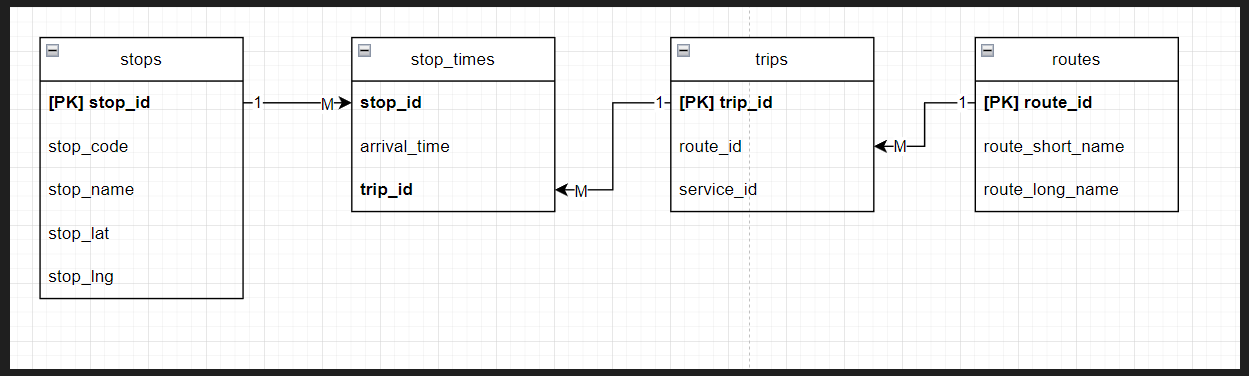

In [37]:
# sanity check size of input files first
print("# trips: \t", trips.shape[0])
print("# stop_times: \t", stop_times.shape[0])


# trips: 	 55189
# stop_times: 	 1690279


In [38]:
# join all data...
data = trips.merge(stop_times, on='trip_id')

In [39]:
data

,trip_id,route_id,service_id,trip_headsign,stop_id,arrival_time
0,13997545,6612,1,2 Macdonald/To Burrard Station,646,5:11:00
1,13997545,6612,1,2 Macdonald/To Burrard Station,1277,5:18:53
2,13997545,6612,1,2 Macdonald/To Burrard Station,1279,5:19:48
3,13997545,6612,1,2 Macdonald/To Burrard Station,56,5:21:05
4,13997545,6612,1,2 Macdonald/To Burrard Station,12619,5:21:39
...,...,...,...,...,...,...
1690274,14321449,6646,201,110 Lougheed Station,2527,15:33:06
1690275,14321449,6646,201,110 Lougheed Station,2528,15:34:06
1690276,14321449,6646,201,110 Lougheed Station,2529,15:34:42
1690277,14321449,6646,201,110 Lougheed Station,2530,15:35:13


In [40]:
# Assert that the join on trip_id key worked
assert data.shape[0] == stop_times.shape[0]

In [41]:
# Check for any null records?
data.isna().any()

trip_id          False
route_id         False
service_id       False
trip_headsign    False
stop_id          False
arrival_time     False
dtype: bool

In [43]:
# remember to clean leading and trailing whitespace from arrival_time strings...
data['arrival_time'] = data['arrival_time'].apply(lambda x: x.strip())

Clean and filter records by the service_ids.

- Not dealing with ~[1, 2, 3] cases.
  - Exceptions in schedules like holidays or special service
- Losing some accuracy in schedule times
  - Non regulr schedules are outside scope of this app
  - Supplements realtime data anyways


Service_id of:

1 -> Monday - Friday

2 -> Saturday

3 -> Sunday

In [44]:
valid_ids = set([1, 2, 3])

In [45]:
data = data[data['service_id'].isin(valid_ids)]

In [46]:
data

,trip_id,route_id,service_id,trip_headsign,stop_id,arrival_time
0,13997545,6612,1,2 Macdonald/To Burrard Station,646,5:11:00
1,13997545,6612,1,2 Macdonald/To Burrard Station,1277,5:18:53
2,13997545,6612,1,2 Macdonald/To Burrard Station,1279,5:19:48
3,13997545,6612,1,2 Macdonald/To Burrard Station,56,5:21:05
4,13997545,6612,1,2 Macdonald/To Burrard Station,12619,5:21:39
...,...,...,...,...,...,...
1690217,14321215,31822,1,741 Haney Place,12468,7:34:14
1690218,14321215,31822,1,741 Haney Place,12469,7:35:24
1690219,14321215,31822,1,741 Haney Place,11305,7:36:07
1690220,14321215,31822,1,741 Haney Place,7856,7:36:54


In [47]:
data = data[['stop_id','route_id','service_id','arrival_time']]
data = data.groupby(['stop_id','route_id','service_id'], as_index=False).agg({'arrival_time': list})
data

,stop_id,route_id,service_id,arrival_time
0,1,30055,1,"[6:00:00, 6:12:00, 6:24:00, 6:36:00, 6:48:00, ..."
1,1,30055,2,"[21:08:00, 21:25:00, 21:42:00, 22:00:00, 22:24..."
2,1,30055,3,"[22:26:00, 22:41:00, 22:56:00, 23:11:00, 23:26..."
3,11,6616,1,"[7:47:45, 16:05:16, 18:21:42, 18:27:42, 7:58:3..."
4,11,6616,2,"[25:50:16, 19:27:59, 18:15:59, 18:39:59, 14:06..."
...,...,...,...,...
38353,13035,6665,2,"[21:34:38, 22:34:38, 6:24:16, 6:54:16, 18:30:2..."
38354,13035,6665,3,"[23:54:59, 12:29:38, 7:29:16, 11:59:38, 13:29:..."
38355,13036,6622,1,"[10:44:37, 11:01:44, 11:16:44, 13:31:51, 13:46..."
38356,13036,6622,2,"[8:52:44, 10:27:58, 7:32:16, 24:25:37, 22:20:3..."


In [53]:
def parse_time_stamps(time):
  hours, minutes, seconds = map(int, time.split(":"))
  total_seconds = hours * 3600 + minutes * 60 + seconds
  return total_seconds

In [55]:
# Sort the arrival times ascending
data['arrival_time'] = data['arrival_time'].apply(lambda x: sorted(x, key=parse_time_stamps))

In [56]:
data.to_json("stop_times.json", orient='records', indent=2)